# **Classificação de Presença de Doenças Cardiacas**
---



## **Instalando dependencias**

In [1]:
!pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importando Métodos e Classes das bibliotecas**

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## **Lendo CSV e Estudando sua estrutura**

In [3]:
url = 'https://raw.githubusercontent.com/GabrielCamargoL/Machine_Learning-FATEC/test/cardioClassification/cardio_train.csv'
cardio = pd.read_csv(url, sep = ';')
cardio.head(5)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## **Pré processamento: Limpeza de ruídos **

In [5]:
# Verifica se existem valores nulos
print(cardio.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [6]:
#Verifica valores Duplicados
cardio.drop_duplicates(inplace=True)
cardio.duplicated().sum()

0

In [7]:
# Remoção de colunas que não são úteis para o algorítmo
cardio = cardio.drop(columns='id')

## **Pré processamento: One-Hot Encoding**

In [8]:
ohe = OneHotEncoder()

# one hot da coluna de glicose (1: normal, 2: alta 3: muito alta)
transformed = ohe.fit_transform(cardio[['cholesterol']])

# inclusão da novas categorias para o datafrae principal
cardio[ohe.categories_[0]] = transformed.toarray()
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,1,2,3
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0.0,0.0,1.0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0.0,0.0,1.0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1.0,0.0,0.0


In [9]:
# Renomeando colunas 1, 2, 3 criadas pelo One-HOT para nomes legiveis

to_rename = {
    1 : 'normal_cholest',
    2 : 'above_cholest',
    3 : 'well_above_cholest',
}

cardio = cardio.rename(columns=to_rename)

#Retirando a coluna pai com os valores nominais
cardio = cardio.drop(['cholesterol'], axis=1)
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,cardio,normal_cholest,above_cholest,well_above_cholest
0,18393,2,168,62.0,110,80,1,0,0,1,0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,1,0,0,1,1,0.0,0.0,1.0
2,18857,1,165,64.0,130,70,1,0,0,0,1,0.0,0.0,1.0
3,17623,2,169,82.0,150,100,1,0,0,1,1,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,1,0,0,0,0,1.0,0.0,0.0


In [10]:
ohe2 = OneHotEncoder()

# one hot da coluna de glicose (1: normal, 2: alta 3: muito alta)
transformed = ohe2.fit_transform(cardio[['gluc']])

# inclusão da novas categorias para o datafrae principal
cardio[ohe2.categories_[0]] = transformed.toarray()
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,cardio,normal_cholest,above_cholest,well_above_cholest,1,2,3
0,18393,2,168,62.0,110,80,1,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,1,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,1,165,64.0,130,70,1,0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,2,169,82.0,150,100,1,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,1,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# Renomeando colunas 1, 2, 3 criadas pelo One-HOT para nomes legiveis
to_rename = {
    1 : 'normal_glucose',
    2 : 'above_glucose',
    3 : 'well_above_glucose',
}

cardio = cardio.rename(columns=to_rename)

#Retirando a coluna pai com os valores nominais
cardio = cardio.drop(['gluc'], axis=1)
cardio.head()


,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,normal_cholest,above_cholest,well_above_cholest,normal_glucose,above_glucose,well_above_glucose
0,18393,2,168,62.0,110,80,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,1,165,64.0,130,70,0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,2,169,82.0,150,100,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


## **Normalizando dados**

In [12]:
# Convertendo idade de dias para Anos
cardio['age'] = cardio['age']/365
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,normal_cholest,above_cholest,well_above_cholest,normal_glucose,above_glucose,well_above_glucose
0,50.391781,2,168,62.0,110,80,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0
1,55.419178,1,156,85.0,140,90,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,51.663014,1,165,64.0,130,70,0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,48.282192,2,169,82.0,150,100,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
4,47.873973,1,156,56.0,100,60,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


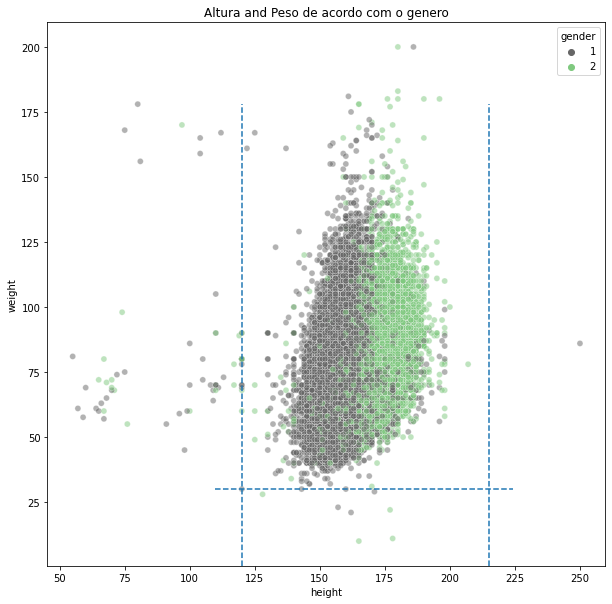

In [13]:
# plotando a relação altura e peso pelo genero
# para captura remoção de outliers
f, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data=cardio, x="height", y="weight",hue='gender',palette="Accent_r", alpha=0.5)
ax.axvline(120, ls='--',ymax=0.85)
ax.axvline(215, ls='--',ymax=0.85)
ax.axhline(30, ls='--',xmin=0.3,xmax=0.835)
plt.title("Altura and Peso de acordo com o genero")
plt.show()

In [14]:
cardio = cardio.query('height >= 120 & height <=215 & weight >= 30')
len(cardio.index)

69940

*Calculando IMC para a análise*

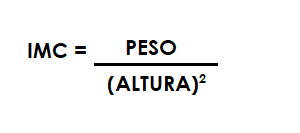

In [15]:
# Calculando IMC (bmi = body mass index) 
cardio['bmi'] = cardio['weight']/((cardio['height']/100)**2)

# retirando os dados de Peso e altura separados ja que temos o IMC
cardio=cardio.drop(['height','weight'],axis=1)

<ipython-input-15-b6074c68204f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardio['bmi'] = cardio['weight']/((cardio['height']/100)**2)


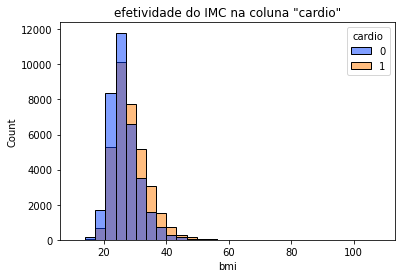

In [16]:
sns.histplot(data=cardio,x='bmi',hue='cardio',bins=30,palette='bright')
plt.title('efetividade do IMC na coluna "cardio"')
plt.show()

**Tabela de Pressão Arterial**

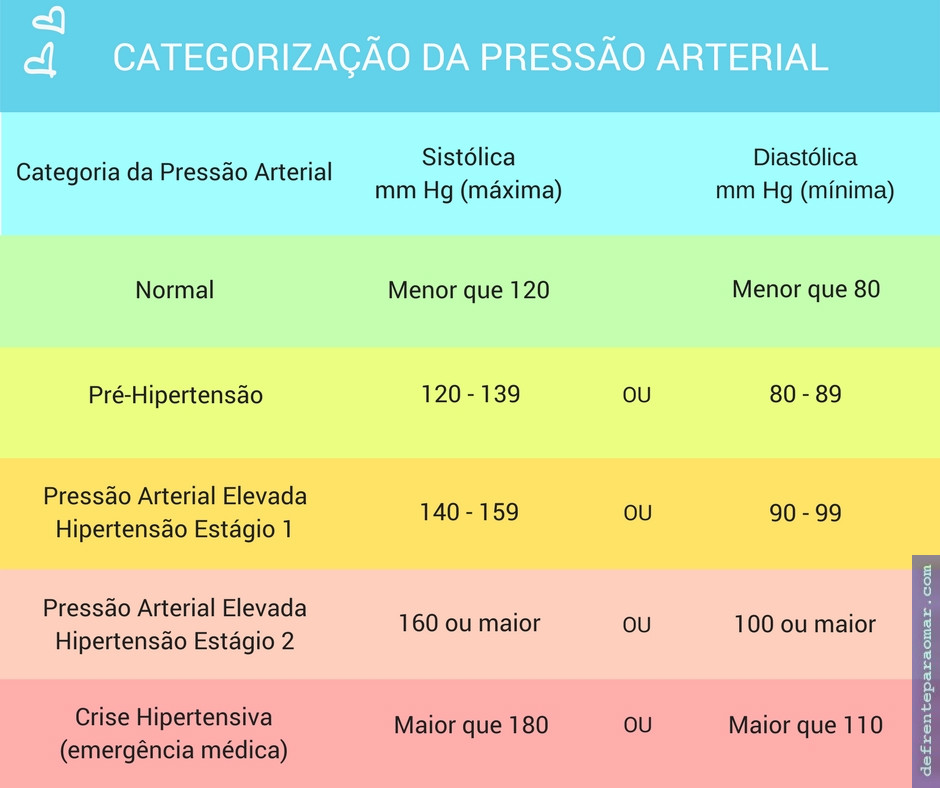

In [17]:
cardio = cardio.query('70 < ap_hi < 240 & 40 < ap_lo < 140 & ap_hi > ap_lo')
len(cardio.index)

68571

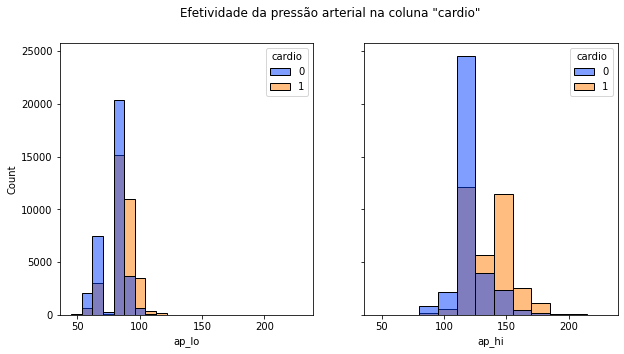

In [18]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True,sharey=True)
sns.histplot(data=cardio, x="ap_hi", hue="cardio",bins=10,palette='bright',ax=axes[1])
sns.histplot(data=cardio, x="ap_lo", hue="cardio",bins=10,palette='bright',ax=axes[0])
f.suptitle('Efetividade da pressão arterial na coluna "cardio"')
plt.show()

In [19]:
cardio = cardio.astype({
            "age": 'int',
            "bmi": 'int',
            "normal_glucose":'int', 
            "above_glucose":'int', 
            "well_above_glucose":'int',
            "normal_cholest":'int',
            "above_cholest":'int',
            "well_above_cholest":'int'
          }) 

cardio.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,normal_cholest,above_cholest,well_above_cholest,normal_glucose,above_glucose,well_above_glucose,bmi
0,50,2,110,80,0,0,1,0,1,0,0,1,0,0,21
1,55,1,140,90,0,0,1,1,0,0,1,1,0,0,34
2,51,1,130,70,0,0,0,1,0,0,1,1,0,0,23
3,48,2,150,100,0,0,1,1,1,0,0,1,0,0,28
4,47,1,100,60,0,0,0,0,1,0,0,1,0,0,23


----------
## **Separando dados para o treino**

In [20]:
X = cardio.drop(['cardio'], axis=1)
y = cardio['cardio']


In [21]:
# Separando 20% entre teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [22]:
categorical_features_indices = np.where(X.dtypes != float)[0]

print(categorical_features_indices)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


## **Treinando...**

In [23]:
model = CatBoostClassifier(
    custom_loss=[metrics.Precision()],
    random_seed=42,
    logging_level='Silent'
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## **Resultado:**

Acuracy: 0.74
Precision: 0.74
Matriz de Confusão


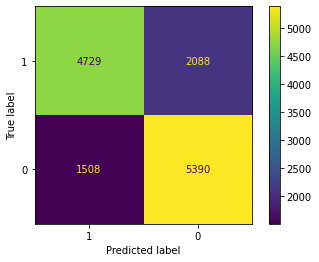

In [24]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Predição
y_pred = model.predict(X_test)

# Acurácia
acc = accuracy_score(y_test, y_pred)
print("Acuracy: {:.2f}".format(acc))

# Precisão
pre = precision_score(y_test, y_pred, average = 'weighted')
print("Precision: {:.2f}".format(pre))

# Matriz de confusão
print('Matriz de Confusão')
cm = confusion_matrix(y_test, y_pred, labels=y_train.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.unique())
disp.plot()
